#**Analyzing stock price history in support of option speculation**
    
In order to maximize their returns, many investors are choosing to speculate with options. Instead of a more conservative approach of investing in stocks or [Exchange Traded Funds (ETFs)](href="https://en.wikipedia.org/wiki/Exchange-traded_fund") and using [options]("https://www.investopedia.com/options-basics-tutorial-4583012") to protect their investments, risk takers are buying and selling options to take advantage of their high potential of return. Since an options contract has an expiration date, part of their value degrades over time, actually every day. Because of this many speculators engage in day trading, buying and selling their contracts within one day. In order to day trade successfully, the investor has to anticipate whether the day will be bearish or bullish for the underlying stock, buying then selling a put contract for the former or buying then selling a call contract for the latter.

One approach used by the options [speculator]("https://www.investopedia.com/ask/answers/06/speculateoptions.asp") is called [technical analysis,]("https://www.investopedia.com/terms/t/technicalanalysis.asp") evaluating statistical trends gathered from trading activity including price and volume. Speculators have access to scores of statistical tools that can aid in predicting a bullish or bearish day. Some of these tools are a bit obscure and understanding how to use them  requires a sophisticated understanding of statistics. Quite a bit, however, can be learned from some simple analyses. One popular ETF used by the options speculator has the symbol SPY and it is based on the [Standard & Poor's 500 index.]("https://en.wikipedia.org/wiki/S%26P_500_Index") SPY options are popular among speculators due to their high volume, weekly expiration dates, one half dollar increments in strike price and very thin spreads, the difference between the bid and ask prices. [Quantopian,]("https://www.quantopian.com/home") an education website for quantitative financial analysis provide free detailed financial data including ETF and stock prices. A time series plot of the SPY ETF for the last four months follows.

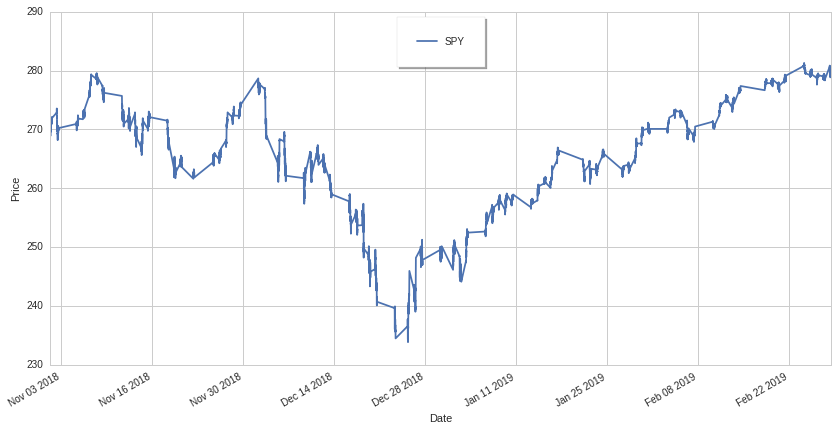

In [243]:
# Research environment functions
from quantopian.research import prices, symbols

# Pandas library: https://pandas.pydata.org/
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Query historical pricing data
asset = 'SPY'
TimeSeriesPrices = prices(
    assets=symbols(asset),
    start='2018-11-01',
    end='2019-03-01', price_field='close', frequency='minute')
TimeSeriesPrices.index.tz = 'US/Pacific'
plt.figure(figsize=(14, 7))
TimeSeriesPrices.plot(label=asset)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper center', borderpad=2, shadow='True')
plt.show()


The data displayed includes prices for only when the market is open, 6:30 AM to 1:00 PM PST. No premarket or after market data is included. The longer lines represent gap up or gap down changes in price during off hours or through the weekends. The data should provide a rich breadth covering both a down and up trend.

One simple addition we can make to the data is to indicate whether the day is a bullish or bearish day by determining the maximum and minimum prices for the day. A bear day is when the maximum price preceded the minimum price for the day, suggesting a purchase then sale of a put. The reverse, the maximum following the minimum for a bull day suggests buying then selling a call. An overlay of the bear and bull days are included below.</p>

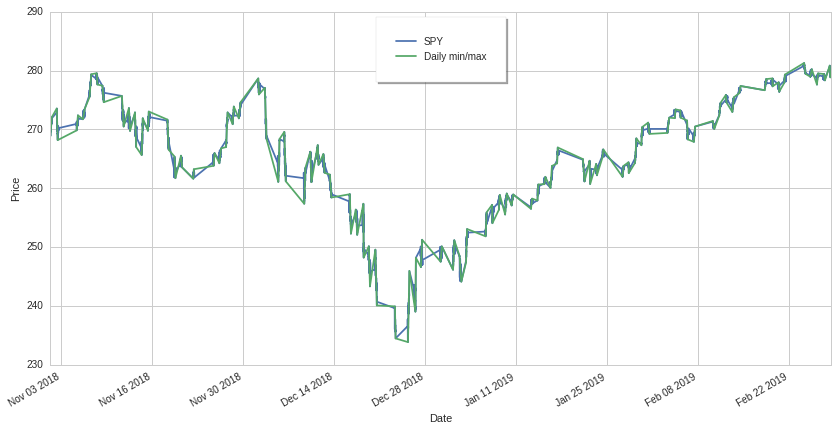

In [244]:
# Find the min and max for each day
dailyMin = TimeSeriesPrices.groupby(TimeSeriesPrices.index.date).nsmallest(1)
dailyMax = TimeSeriesPrices.groupby(TimeSeriesPrices.index.date).nlargest(1)

# clean up the series' indexing
dailyMin.index = dailyMin.index.droplevel(0)
dailyMax.index = dailyMax.index.droplevel(0)

# blend the mins and maxes
lines = dailyMin.append(dailyMax)
lines.sort_index(inplace=True)
plt.figure(figsize=(14, 7))
TimeSeriesPrices.plot(label=asset)
lines.plot(label='Daily min/max')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper center', borderpad=2, shadow='True')
plt.show()


It's a little hard to see the data so, zooming in to the last week in February -

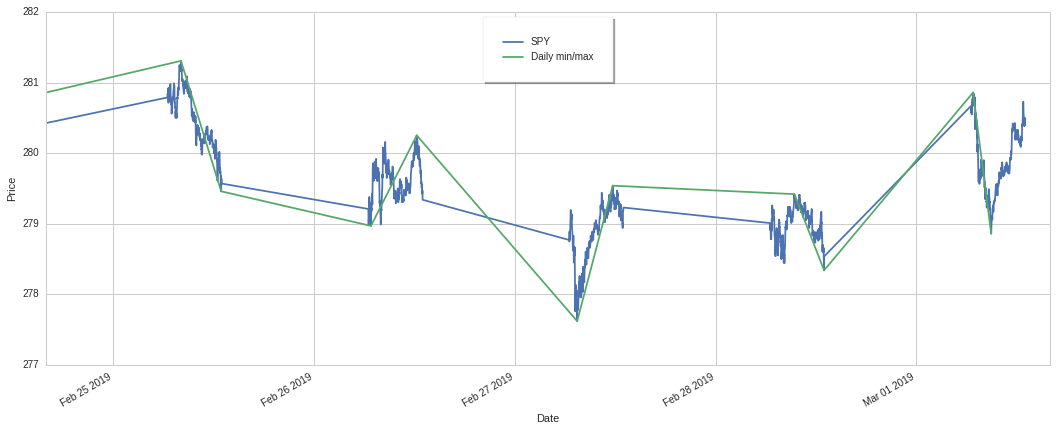

In [245]:
# Adjust the upper and lower dates for the plot to zoom in
begin = pd.Timestamp('2019-02-25')
end = pd.Timestamp('2019-03-02')
plt.figure(figsize=(18, 7))
TimeSeriesPrices.plot(xlim=(begin, end), label=asset)
lines.plot(xlim=(pd.Timestamp('2019-02-25'), pd.Timestamp('2019-03-02')),
           ylim=(277, 282), label='Daily min/max')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper center', borderpad=2, shadow='True')
plt.show()

It looks as though Monday, Thursday and Friday were bear days, and Tuesday and Wednesday were bulls. Again, holding  contracts overnight or over the weekend are not recommended due to the contracts losing value as they age. Actually, it looks as though Friday and Wednesday could be split in two yielding a sawtooth day of a bearish trend followed by a bull, but that might be hard to predict and execute the buying and selling of option contracts that precisely.

Before we delve too heavily into the bear/bull data, let's gather a few statistics on, and provide some alternate visualizations of the price data, again for November 2018 through February 2019. Included below are values that describe the shape and statistical parameters of the data, a histogram, overall boxplot and a daily boxplot. Note that the distribution is heavily <a href="https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/skewed-distribution/#SkewLeft">left-skewed</a>, resulting from infrequent but sharp, short downturns from the norm followed by quick recoveries.

In [246]:
TimeSeriesPrices.shape

(31230,)

In [247]:
from collections import Counter
print (TimeSeriesPrices.describe())
print ('median ', TimeSeriesPrices.median())
mode = Counter(TimeSeriesPrices).most_common(1)
print('mode ', mode)

count    31230.000000
mean       265.650364
std         10.089265
min        233.830000
25%        260.093000
50%        266.553000
75%        272.817000
max        281.309000
Name: Equity(8554 [SPY]), dtype: float64
('median ', 266.553)
('mode ', [(279.19999999999999, 25)])


OK Python, build a histogram.

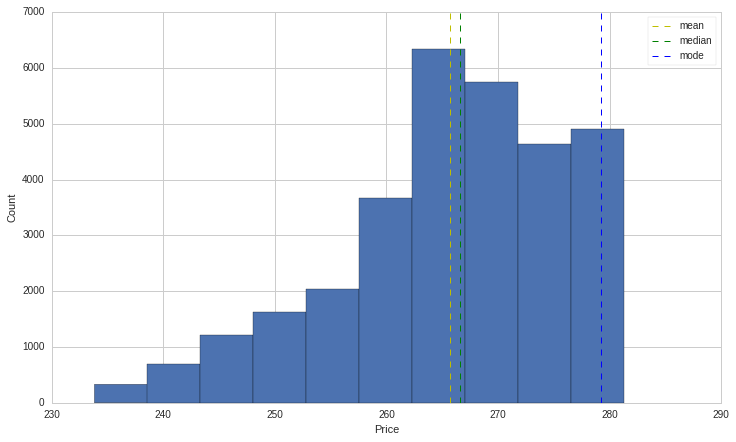

In [248]:
# Build a histogram
#***************************8TimeSeriesPrices.plot.hist()
plt.figure(figsize=(12, 7))
plt.hist(TimeSeriesPrices.dropna())
plt.axvline(TimeSeriesPrices.mean(), label='mean', color='y',
            linestyle='dashed', linewidth=1)
plt.axvline(TimeSeriesPrices.median(), label='median', color='g',
            linestyle='dashed', linewidth=1)
plt.axvline(TimeSeriesPrices.mode()[0], label='mode', color='b',
            linestyle='dashed', linewidth=1)
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()


OK Python, buid a boxplot.

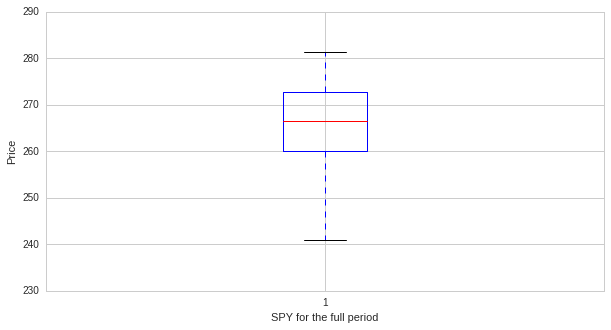

In [249]:
# Build an overall boxplot
# TimeSeriesPrices.plot.box(label=asset +' for the full period')
plt.figure(figsize=(10, 5))
plt.boxplot(TimeSeriesPrices)
plt.xlabel(asset + ' for the full period')
plt.ylabel('Price')
plt.show()


Now, build a daily boxplot.

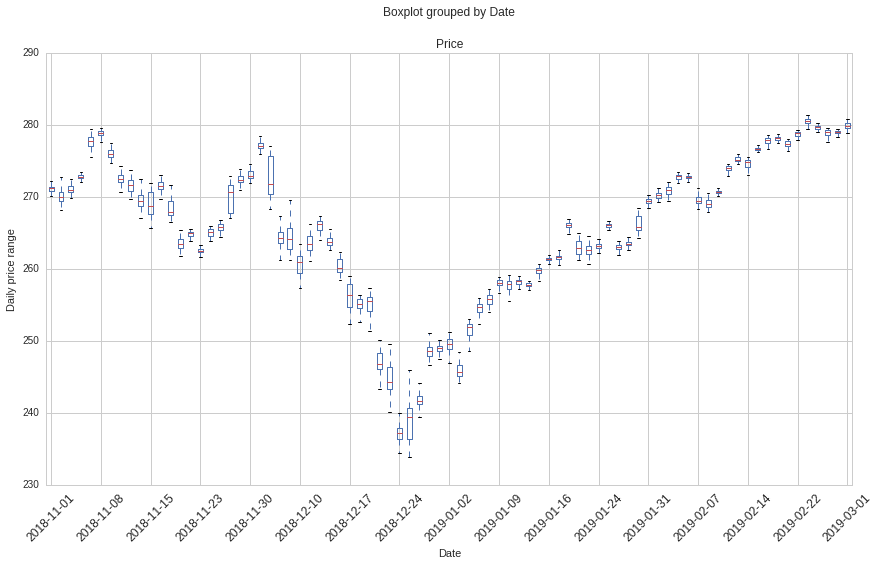

In [250]:
# Build a daily boxplot
priceDF = pd.DataFrame(TimeSeriesPrices)
priceDF.columns = ['Price']
priceDF.insert(loc=0, column='Date', value=priceDF.index.date)
plt.figure(figsize=(10, 5))
priceDF.boxplot(column='Price', by='Date')
ticks, labels = plt.xticks()
newTicks = []
newLabels = []
for i in range(1, len(ticks)+1, 5):
    newTicks.append(i)
    newLabels.append(labels[i-1])
plt.xticks(newTicks, newLabels, rotation=45)
plt.ylabel('Daily price range')
plt.show()


Let's count the bull and bear days.

In [251]:
# Let's count the bull and bear days.
bullBear = []
for i in range(0, len(lines), 2):
    if lines[i] > lines[i+1]:
        bullBear.append('Bear')
    else:
        bullBear.append('Bull')
Counter(bullBear)


Counter({'Bear': 38, 'Bull': 43})

Not surprisingly, due to the symmetry of the data, the number of bull and bear days are roughly equal. Even if a speculator could predict a bull or bear day, correct timing of when to buy and sell is essential. Let's take a look at the time of day for buying and selling. 

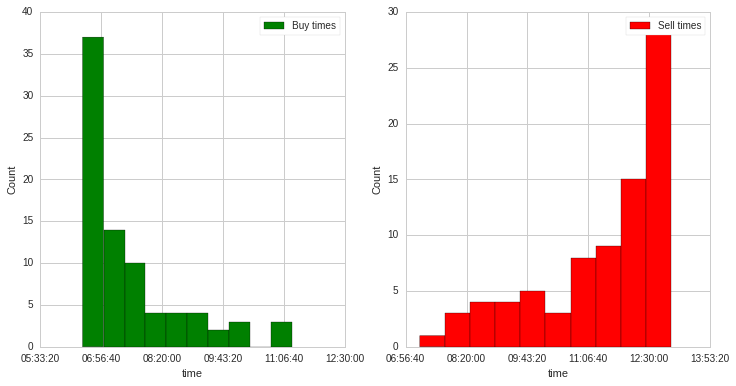

In [252]:
# Build histograms for buying and selling
buyTimes = []
sellTimes = []
for i in range(0, len(lines), 2):
    buyTimes.append(lines.index[i].time())
    sellTimes.append(lines.index[i+1].time())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(buyTimes, label='Buy times', color='g')
plt.legend()
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(sellTimes, label='Sell times', color='r')
plt.legend()
plt.ylabel('Count')
plt.show()


At first glance, using the peak times, one would assume that you should buy between 6:30 and 8:00 and sell between 11:00 and 13:00. One might assume that indicates a hold time of five hours. Let's take a different look and bin the hold times for each day by differencing the times first and binning the difference.

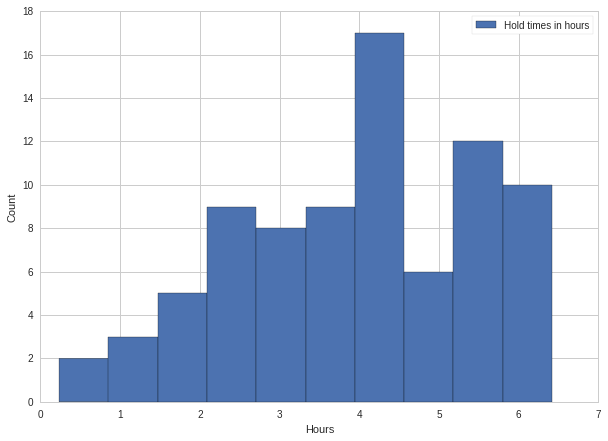

In [253]:
# Build histogram for hold time
holdTimeHrs = []
for i in range(0, len(buyTimes), 1):
    dateTimeBuy = datetime.datetime.combine(datetime.date.today(), buyTimes[i])
    dateTimeSell = datetime.datetime.combine(datetime.date.today(),
                                             sellTimes[i])
    holdTimeHrs.append((dateTimeSell - dateTimeBuy).total_seconds() / 3600)
plt.figure(figsize=(10, 7))
plt.hist(holdTimeHrs, label='Hold times in hours')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.legend()
plt.show()


In [254]:
#print ('mean ',holdTimeHrs.mean() )
#print ('median ', holdTimeHrs.median() )
#mode = Counter(holdTimeHrs).most_common(1)
#print('mode ',mode)

One interesting question is whether a sharp price gap between the market close and open can predict whether the next day is a bull or bear. Conversely, can a bullish or bearish day predict how the price will gap befor the next market open? Let's take a look at that.

OK Python, build list of gap ups and downs and initialize the list and the looping index and find the gaps in the price time series.

Counter({'gapUp': 41, 'gapDown': 39})


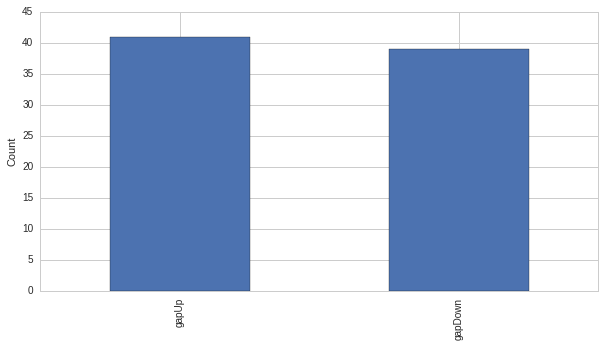

In [255]:
# Build a series of gap ups and downs
# Initalize gaps list and the looping index
gaps = pd.Series(['NA'] * (len(bullBear) - 1))
j = 0
# find gaps in time series
for i in range(0, (len(TimeSeriesPrices) - 1), 1):
    if (TimeSeriesPrices.index[i].date() !=
       TimeSeriesPrices.index[i+1].date()):
        # We've found a gap
        if (TimeSeriesPrices[i] > TimeSeriesPrices[i+1]):
            gaps[j] = 'gapDown'
        else:
            gaps[j] = 'gapUp'
        j += 1
plt.figure(figsize=(10, 5))
gaps.value_counts().plot(kind='bar')
print (Counter(gaps))
plt.ylabel('Count')
plt.show()


Again due to the symmetry of the data about the December low, the gaps are neutral. Let's continue to see if there is any correlation between the gaps and bull/bear data to explore predictability. Let's build the gapPredictsDay and dayPredictsGap series.

('Gap Predicts Day ', Counter({'gapUp->Bull': 21, 'gapDown->Bull': 21, 'gapUp->Bear': 20, 'gapDown->Bear': 18}))
('Day Predicts Gap ', Counter({'Bull->gapUp': 22, 'Bull->gapDown': 21, 'Bear->gapUp': 19, 'Bear->gapDown': 18}))


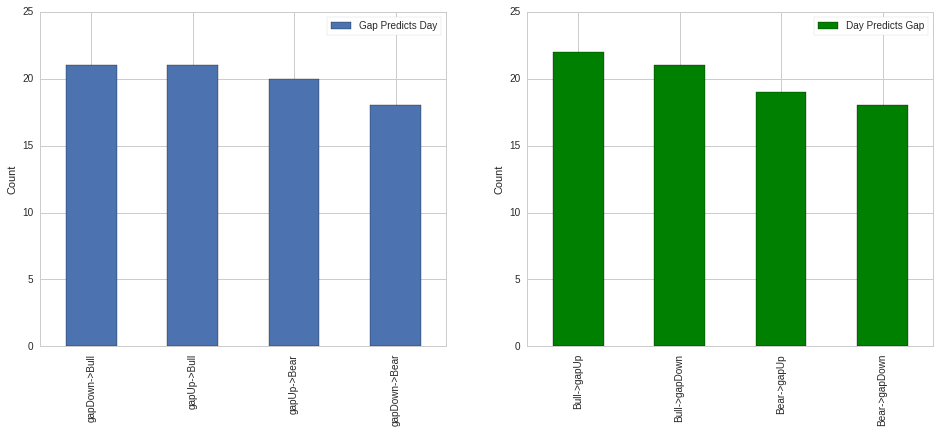

In [256]:
# Build the gapPredictsDay and dayPredictsGap series
gapPredictsDay = pd.Series(['NA'] * len(gaps))
dayPredictsGap = pd.Series(['NA'] * len(gaps))
for i in range(0, len(gaps), 1):
    gapPredictsDay[i] = gaps[i] + '->' + bullBear[i+1]
    dayPredictsGap[i] = bullBear[i] + '->' + gaps[i]

# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
gapPredictsDay.value_counts().plot(kind='bar', label='Gap Predicts Day')
plt.legend()
plt.ylabel('Count')
plt.subplot(1, 2, 2)
dayPredictsGap.value_counts().plot(kind='bar',
                                   color='g', label='Day Predicts Gap')
plt.legend()
plt.ylabel('Count')

print('Gap Predicts Day ', Counter(gapPredictsDay))
print('Day Predicts Gap ', Counter(dayPredictsGap))
plt.show()


Once again, nothing significant is revealed. All eight combinations that include gaps predicting market directions or vice versa occur at roughly the same frequencies. Any slight descrepency is just indicative of the overall price trend for the period chosen.
    
Adding one more criterion, looking for triad patterns yields -

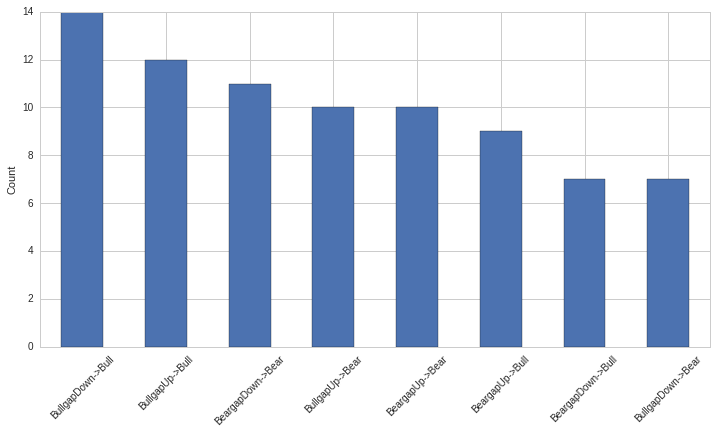

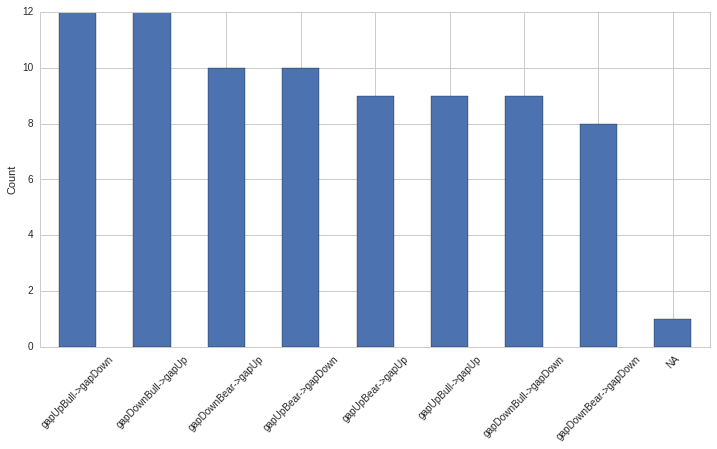

In [257]:
# Build the gapPredictsDay and dayPredictsGap lists
gapDayPredictsGap = pd.Series(['NA'] * len(gaps))
dayGapPredictsDay = pd.Series(['NA'] * len(gaps))
for i in range(0, len(gaps) - 1, 1):
    gapDayPredictsGap[i] = gaps[i] + bullBear[i+1] + '->' + gaps[i+1]
for i in range(0, len(bullBear) - 1, 1):
    dayGapPredictsDay[i] = bullBear[i] + gaps[i] + '->' + bullBear[i+1]

plt.figure(figsize=(12, 6))
dayGapPredictsDay.value_counts().plot('bar')
plt.ylabel ('Count')
plt.xticks(rotation=45)

plt.figure(figsize=(12, 6))
gapDayPredictsGap.value_counts().plot('bar')
plt.ylabel ('Count')
plt.xticks(rotation=45)

plt.show()


The only interesting signal is that a GapDown followed by a bearish day is more likely to precede a GapDown than a GapUp. This could result from a low sample size. A follow on project is suggested in looking at a multi-year sample, possibly just looking at daily  highs and lows and not intraday data. One could apply Bayes Theorem -    
    
$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$

to these double signals to see if they could be applied as a test to predict a GapDown.
    
$$ P(GapDown \mid GapDownBear) = \frac{P(GapDownBear \mid GapDown) \, P(GapDown)}{P(GapDownBear)} $$

